# Imports

In [1]:
# OS interaction
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Data Manipulation
import pandas as pd

# Pandas Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Linear Algebra
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# DateTime Manipulation
import datetime as dt
import pytz
from pandas.tseries.holiday import *
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import *

In [3]:
!ls ..

assets	data  docs  notebooks  src


In [5]:
project_dir = os.path.abspath('..')
data_path = '/data/processed/detroit_911_calls_cleaned.csv'

csv_path = project_dir + data_path


df = pd.read_csv(csv_path)

# Load Data

In [6]:
print(df.shape)
df.head(3)

(2727156, 24)


,X,Y,incident_id,agency,incident_address,zip_code,priority,callcode,calldescription,category,call_timestamp,precinct_sca,respondingunit,officerinitiated,intaketime,dispatchtime,traveltime,totalresponsetime,time_on_scene,totaltime,neighborhood,block_id,council_district,oid
0,-82.986962,42.408358,201626400002,DPD,Promenade Ave & Roseberry St,48213,3,825030,DISTURBANCE,DISTURB,2016-09-20T09:36:12.000Z,910A,NaN,No,2.2,528.6,15.5,546.6,120.5,667.1,Wade,2.616350e+14,4.0,260872651
1,-83.185213,42.430914,201626400019,DPD,Ardmore St & W 7 Mile Rd,48235,2,811020,AUTO X UNK INJ / IMPAIRED,ACCUNK,2016-09-20T09:46:32.000Z,1201,NaN,No,2.7,5.2,6.4,14.5,59.1,73.6,Tri-Point,2.616354e+14,2.0,260872652
2,-83.146057,42.438770,201626400020,DPD,Pembroke Ave & Prairie St,48221,3,374030,RECOVER AUTO,RECAUTO,2016-09-20T09:48:24.000Z,123B,NaN,No,4.9,NaN,NaN,NaN,NaN,NaN,Oak Grove,2.616354e+14,2.0,260872653


#### Initial Filtering

The first logical step here is to move forward with only the columns we will be needing for this project. The most obvious of course are X and Y our longitude and latitude coordinates, as well as the call_timestamp, priority and call description. The rest of the columns will be unnecessary for our purposes.

In [7]:
pertinent_cols = [
    'X', 
    'Y',
    'call_timestamp',
    'calldescription',
    'priority'
]

df2 = df[pertinent_cols]

#    correct calldescription header to fit convention
df2 = df2.rename(columns={'calldescription':'call_description'})


df2.head(3)

,X,Y,call_timestamp,call_description,priority
0,-82.986962,42.408358,2016-09-20T09:36:12.000Z,DISTURBANCE,3
1,-83.185213,42.430914,2016-09-20T09:46:32.000Z,AUTO X UNK INJ / IMPAIRED,2
2,-83.146057,42.438770,2016-09-20T09:48:24.000Z,RECOVER AUTO,3


### Secondary Filtering

If we examine the call_description column we will find that not all observations relate to 911 responses, rather they represent administrative functions

In [8]:
df2.call_description.value_counts()[:20]

SPECIAL ATTENTION                 393478
TRAFFIC STOP                      385731
DISTURBANCE                       186912
START OF SHIFT INFORMATION        151182
REMARKS                           139002
INVESTIGATE PERSON                104818
UNKNOWN PROBLEM                    95698
HANGUP CALLS                       88672
TOWING DETAIL                      76439
ASSAULT AND BATTERY                72014
FELONIOUS ASSAULT IP               47555
BUS BOARDING                       44551
LARCENY REPORT                     41048
AUTO X UNK INJ / IMPAIRED          36121
VERIFIED ALR / PERSON W/O CODE     28770
UDAA REPORT                        28114
PERSON WITH WEAPON                 26513
BURGLARY OCCUPIED RESD I/P         25261
SHOTS FIRED IP                     24837
INVESTIGATE AUTO                   24437
Name: call_description, dtype: int64

There are 2 call descriptions describing non-police functions, 'START OF SHIFT INFORMATION' and 'REMARKS'. So lets define our dataframe to include all the observations save for ones where the call description contains those values

In [9]:
admin_calls = df2.call_description.value_counts()[3:5]

In [10]:
admin_calls = list(df2.call_description.value_counts()[3:5].index)
print(admin_calls)

# Lets take out the crank calls too
removed_calls = set(admin_calls + ['HANGUP CALLS'])

df3 = df2.loc[~df2['call_description'].isin(removed_calls)]

print(df3.shape)
df3.head(3)

['START OF SHIFT INFORMATION', 'REMARKS']
(2348300, 5)


,X,Y,call_timestamp,call_description,priority
0,-82.986962,42.408358,2016-09-20T09:36:12.000Z,DISTURBANCE,3
1,-83.185213,42.430914,2016-09-20T09:46:32.000Z,AUTO X UNK INJ / IMPAIRED,2
2,-83.146057,42.438770,2016-09-20T09:48:24.000Z,RECOVER AUTO,3


# DateTime

First thing to be done here is to parse the call timestamps and encode each aspect of the DateTime information as a seperate column, we will also notice here that the timestamps use UTC time, so it would also make sense to localize the timezone as we move forward.

In [11]:
def extract_dt_cols(df: pd.DataFrame, col: str,
                    drop_original: bool = True)-> pd.DataFrame:
    """Extracts datetime features from a series of timestamps

    Arguments:
        df {pd.Dataframe} -- The pandas dataframe containing the timestamp
        feature
        col {str} -- The name of the column
        drop_original {boolean} -- default is True, drops column passed in col
        argument from the dataframe

    Returns:
        pd.DataFrame -- DataFrame with the extracted features appended
    """
    df = df.copy()
    
    df[col] = pd.to_datetime(df[col])
    # localize the data
    df[col] = df[col].dt.tz_convert('America/Detroit')

    df['year']  = df[col].dt.year
    df['month'] = df[col].dt.month
    df['day']   = df[col].dt.day
    df['dow']   = df[col].dt.dayofweek
    df['week']  = df[col].dt.week
    df['hour']  = df[col].dt.hour
    
    if drop_original is True:
        df = df.drop(columns=col)

    return df

def get_day_part(df: pd.DataFrame, hour_col: str)-> pd.DataFrame:
    """Extacts the time of day from the hour value by dividing by the hour
     knife
    1 = Morning  (0400 - 1000h)
    2 = Midday   (1000 - 1600h)
    3 = Evening  (1600 - 2200h)
    4 = Night    (2200 - 0400h)

    Arguments:
        df {pd.DataFrame} -- dataframe containing the hour column
        hour_col {str} -- name of the hour column

    Returns:
        pd.DataFrame -- pandas dataframe with the new column appended
    """
    
    df = df.copy()
    hour_knife = 6
    df['part_of_day'] = ((df['hour'] + 2) / hour_knife).astype(int)
    df['part_of_day'] = df['part_of_day'].replace(0, 4)

    return df

class HolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('NewYearsDay', month=1, day=1,
                observance=nearest_workday),
        USMartinLutherKingJr,
        
        Holiday('SuperBowl', month=2, day=1,
                offset=DateOffset(weekday=SU(1))),
        USPresidentsDay,
        
        Holiday('StPatricksDay', month=3, day=17),
        GoodFriday,
        
        Holiday('Easter', month=1, day=1,
                offset=Easter()),        
        USMemorialDay,
        
        Holiday('USIndependenceDay', month=7, day=4,
                observance=nearest_workday),
        USLaborDay,
        
        Holiday('Halloween', month=10, day=31),
        USThanksgivingDay,
        
        Holiday('Christmas', month=12, day=25,
                observance=nearest_workday),
        
        Holiday('NewYearsEve', month=12, day=31,
                observance=nearest_workday)
    ]
    
    
    
    def get_holidays(start, end):
        """
        Returns an index of holidays from HolidayCalendar
        
        args: 
        
        start = str in YYYY/MM/DD format if month or day is not specified
        then defaults to 1
        
        end = str in YYYY/MM/DD format if month or day is not specified
        then defaults to 1
        
        """
        inst = HolidayCalendar()
        sy   = pd.to_datetime(start).year
        sm   = pd.to_datetime(start).month
        sd   = pd.to_datetime(start).day
        
        ey   = pd.to_datetime(end).year
        em   = pd.to_datetime(end).month
        ed   = pd.to_datetime(end).day
        
        holidays = inst.holidays(dt.datetime(sy, sm ,sd), dt.datetime(ey, em, ed))
        
        
        return inst.holidays(dt.datetime(sy, sm ,sd), dt.datetime(ey, em, ed))

def calendar_as_dataframe(index, col='date'):
    
    df = pd.DataFrame(index, columns=[col])
    
    df['year']  = df[col].dt.year
    df['month'] = df[col].dt.month
    df['day']   = df[col].dt.day
    
    df = df.drop(columns=col)
    
    return df

In [12]:
def timestamp_wrangler(df: pd.DataFrame)-> pd.DataFrame:
    """
    """
    
    
    # Extract timestamp columns
    df = extract_dt_cols(
        df=df,
        col='call_timestamp'
    )
    
    # Determine call part of day
    df = get_day_part(
        df=df,
        hour_col = 'hour'
    )
    
    # Get DataFrame of Holidays and events
    holidays = calendar_as_dataframe(
        HolidayCalendar.get_holidays(
            start='2016/9/20',
            end='2020/02/24')
    )
    
    holidays['is_holiday'] = 1
    
    # Create calendar as DataFrame of date ranges 
    calendar = calendar_as_dataframe(
        pd.date_range(
            start='2016/9/20',
            end='2019/02/24')
    )
    
    # Merge calendar and holiday dataframes
    merged = pd.merge(
        calendar,
        holidays,
        how='left'
    )
    
    # Add is_holiday feature to main dataframe
    df = pd.merge(
        df,
        merged,
        how='left',
        on=[
            'year',
            'month',
            'day'
        ]
    )
    df['is_holiday'].fillna(0, inplace=True)
    
    return df

In [13]:
df4 = timestamp_wrangler(df3).drop_duplicates()

In [14]:
df4

,X,Y,call_description,priority,year,month,day,dow,week,hour,part_of_day,is_holiday
0,-82.986962,42.408358,DISTURBANCE,3,2016,9,20,1,38,5,1,0.0
1,-83.185213,42.430914,AUTO X UNK INJ / IMPAIRED,2,2016,9,20,1,38,5,1,0.0
2,-83.146057,42.438770,RECOVER AUTO,3,2016,9,20,1,38,5,1,0.0
3,-83.191603,42.358257,DISTURBANCE,3,2016,9,20,1,38,5,1,0.0
4,-83.175124,42.360867,RECOVER AUTO,3,2016,9,20,1,38,5,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2349865,-83.143162,42.356991,TRAFFIC STOP,2,2020,2,22,5,8,19,3,0.0
2349866,-83.065166,42.348726,TRAFFIC STOP,2,2020,2,22,5,8,19,3,0.0
2349867,-83.197221,42.425061,INVESTIGATE PERSON,3,2020,2,22,5,8,19,3,0.0
2349868,-83.064139,42.351578,PARKING COMPLAINT,3,2020,2,22,5,8,19,3,0.0


***
## Geographic Features
***

#### Let's plot latitude and longitude coordinates and take a look to see if there might be any issues there 

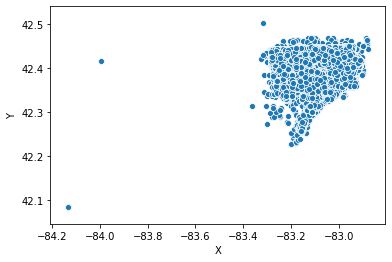

In [15]:
geo_sample = df4[['X', 'Y']].sample(100000,
                                   random_state=42)

sns.scatterplot(
    data=geo_sample,
    x='X',
    y='Y');

>![Detroit City Limits](../assets/DetroitCityLimits.png)

#### I would say that we have a couple outliers skewing the data so now to think the best way to go about removing them
There are a number of ways we could attack this but for now I think it would be best if we went ahead and defined latitudes and longitudes closest to the city limits and used those to exclude from our data those values which fall outside the bounds of the city.

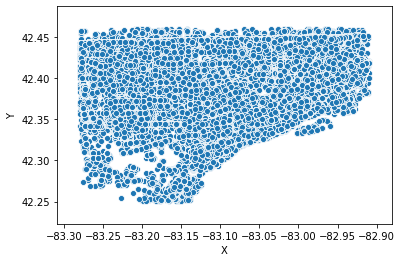

In [34]:
def rm_geo_outliers(df):
    """
    Filters out the outliers in the data where the latitude and longitudes 
    exist outside the geographic limits of the city of Detroit
    """
    limit = {
        "N": 42.46,
        "E": -82.91,
        "S":  42.25,
        "W": -83.28
    }
    
    #  Retains only those observations within the geographic boundaries
    df = df.loc[((df['X'] > limit['W']) & (df['X'] < limit['E'])) &
                ((df['Y'] > limit['S']) & (df['Y'] < limit['N'] ))]
    
    return df

df5 = rm_geo_outliers(df4)

sns.scatterplot(
    data=df5,
    x='X',
    y='Y');

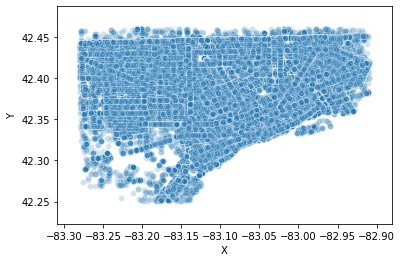

In [40]:
sns.scatterplot(
    data=df5,
    x='X',
    y='Y',
    alpha=0.2);

---
## Experimenting with KMeans as a way to detect geographic outliers
---

In [41]:
import numpy as np
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

X = np.array(df5[['X', 'Y']].sample(100000))

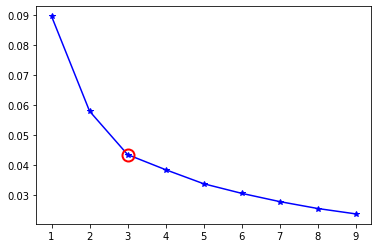

In [90]:
K = range(1,10)

  # scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

kIdx = 2
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')

# Predict Clusters & Plot
km = KMeans(10, init='k-means++')
km.fit(X)
c = km.predict(X)

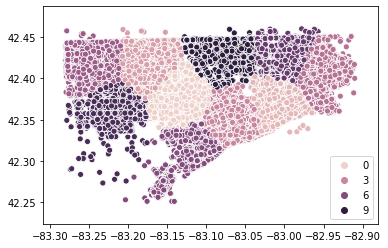

In [99]:
sns.scatterplot(x=list(X[:, :1]), y=list(X[:, 1:]), hue=c)

### This is definitely something we should  
### come back to later, but for now lets keep
### moving with the task at hand
 
  
   
    
     

___
  
  
  
___

 ## <center> Lets get to some feature engineering </center>
 ---
 
 Our next step is to define and apply a function which will assign a grid coordinate to each location in our dataset.
 
 To make this happen we only need to apply some basic math to the problem. 

In [101]:
df5

,X,Y,call_description,priority,year,month,day,dow,week,hour,part_of_day,is_holiday
0,-82.986962,42.408358,DISTURBANCE,3,2016,9,20,1,38,5,1,0.0
1,-83.185213,42.430914,AUTO X UNK INJ / IMPAIRED,2,2016,9,20,1,38,5,1,0.0
2,-83.146057,42.438770,RECOVER AUTO,3,2016,9,20,1,38,5,1,0.0
3,-83.191603,42.358257,DISTURBANCE,3,2016,9,20,1,38,5,1,0.0
4,-83.175124,42.360867,RECOVER AUTO,3,2016,9,20,1,38,5,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2349865,-83.143162,42.356991,TRAFFIC STOP,2,2020,2,22,5,8,19,3,0.0
2349866,-83.065166,42.348726,TRAFFIC STOP,2,2020,2,22,5,8,19,3,0.0
2349867,-83.197221,42.425061,INVESTIGATE PERSON,3,2020,2,22,5,8,19,3,0.0
2349868,-83.064139,42.351578,PARKING COMPLAINT,3,2020,2,22,5,8,19,3,0.0


In [149]:
def geospatial_grid(df, lon, lat):
    df = df.copy()
    # assign a tolerance
    epsilon = .0001
    
    # min and max of latitude and longitude
    lat_min = df[lat].min() - epsilon
    lat_max = df[lat].max() + epsilon
    
    lon_min = df[lon].min() - epsilon
    lon_max = df[lon].max() + epsilon
    
    # ranges
    lat_range = lat_max - lat_min
    lon_range = lon_max - lon_min
    
    # splits
    lat_knife = 20
    lon_knife = 30 
    
    # grid lengths
    lon_length = lon_range / lon_knife
    lat_length = lat_range / lat_knife
    
    # assigining the locations to a grid space
    
    df['lat_grid'] = (np.floor(((df[lat]-lat_min)/lat_length)))
    df['lon_grid'] = (np.floor(((df[lon]-lon_min)/lon_length)))
    
    
    # discard the now unneeded columns
    cols = [lat, lon]
    df = df.drop(columns=cols)
    
    return df

In [150]:
geospatial_grid(df5,
                lon='X',
                lat='Y')

,call_description,priority,year,month,day,dow,week,hour,part_of_day,is_holiday,lat_grid,lon_grid
0,DISTURBANCE,3,2016,9,20,1,38,5,1,0.0,15.0,23.0
1,AUTO X UNK INJ / IMPAIRED,2,2016,9,20,1,38,5,1,0.0,17.0,7.0
2,RECOVER AUTO,3,2016,9,20,1,38,5,1,0.0,17.0,10.0
3,DISTURBANCE,3,2016,9,20,1,38,5,1,0.0,10.0,7.0
4,RECOVER AUTO,3,2016,9,20,1,38,5,1,0.0,10.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2349865,TRAFFIC STOP,2,2020,2,22,5,8,19,3,0.0,10.0,11.0
2349866,TRAFFIC STOP,2,2020,2,22,5,8,19,3,0.0,9.0,17.0
2349867,INVESTIGATE PERSON,3,2020,2,22,5,8,19,3,0.0,16.0,6.0
2349868,PARKING COMPLAINT,3,2020,2,22,5,8,19,3,0.0,9.0,17.0


In [151]:
grid_df = df5.groupby(['lat_grid','lon_grid']).size().reset_index(name='call_count')

In [152]:
grid_df[:10]

,lat_grid,lon_grid,call_count
0,0.0,8.0,1
1,0.0,12.0,3
2,0.0,13.0,3
3,0.0,14.0,2
4,0.0,15.0,5
5,0.0,16.0,57
6,0.0,17.0,20
7,0.0,18.0,31
8,0.0,19.0,7
9,0.0,20.0,7


In [153]:
def to_heatmap_format(df):
    grid_df = df.groupby(['lat_grid','lon_grid']).size().reset_index(name='call_count')
    geoheatmap_df = grid_fg.pivot(index='lat_grid',columns='lon_grid', values='call_count')
    
    return geoheatmap_df

def plot_calls_grid(df):
    fig, ax = plt.subplots(figsize=(20,8))
    plt.title("Detroit 911 Calls by Geographic Location Halloween 2018",
             fontsize=24)

    ax = sns.heatmap(
        data=df,
        annot=False,
        cbar=False)

    # ax.set_ylim(len('lat_grid'), -1, -1)

    fig.set_facecolor('.1')
    ax.set_facecolor('.1')


    ax.invert_yaxis()
    
    return plt.show();

In [160]:
geoheatmap_df = grid_df.pivot(index='lat_grid',columns='lon_grid', values='call_count')
geoheatmap_df

lon_grid,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0
lat_grid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,3.0,3.0,2.0,5.0,57.0,20.0,31.0,7.0,7.0,4.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,1.0,1.0,10.0,27.0,243.0,575.0,7.0,4.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,3.0,5.0,3.0,30.0,2044.0,1085.0,748.0,19.0,7.0,13.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,1.0,1.0,3.0,NaN,NaN,1.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,8.0,10.0,NaN,433.0,1440.0,1621.0,193.0,4.0,3.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,1.0,NaN,NaN,NaN,8.0,2.0,1.0,1.0,4.0,5.0,NaN,9.0,16.0,1.0,8.0,7.0,3.0,NaN,74.0,623.0,3715.0,1501.0,74.0,11.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,2.0,NaN,NaN,7.0,3.0,1.0,1.0,2.0,4.0,34.0,1.0,5.0,NaN,3.0,2.0,NaN,14.0,NaN,48.0,1790.0,956.0,400.0,5.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,2.0,3.0,3.0,NaN,9.0,2.0,2.0,5.0,4.0,1.0,NaN,1.0,2.0,NaN,NaN,6.0,108.0,132.0,7.0,272.0,3.0,NaN,56.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,32.0,1.0,NaN,2.0,5.0,4.0,NaN,NaN,2.0,1.0,42.0,NaN,NaN,NaN,NaN,1.0,1.0,351.0,189.0,170.0,529.0,510.0,172.0,253.0,138.0,174.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,NaN,4.0,4.0,7.0,6.0,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,95.0,79.0,8.0,623.0,966.0,291.0,432.0,391.0,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


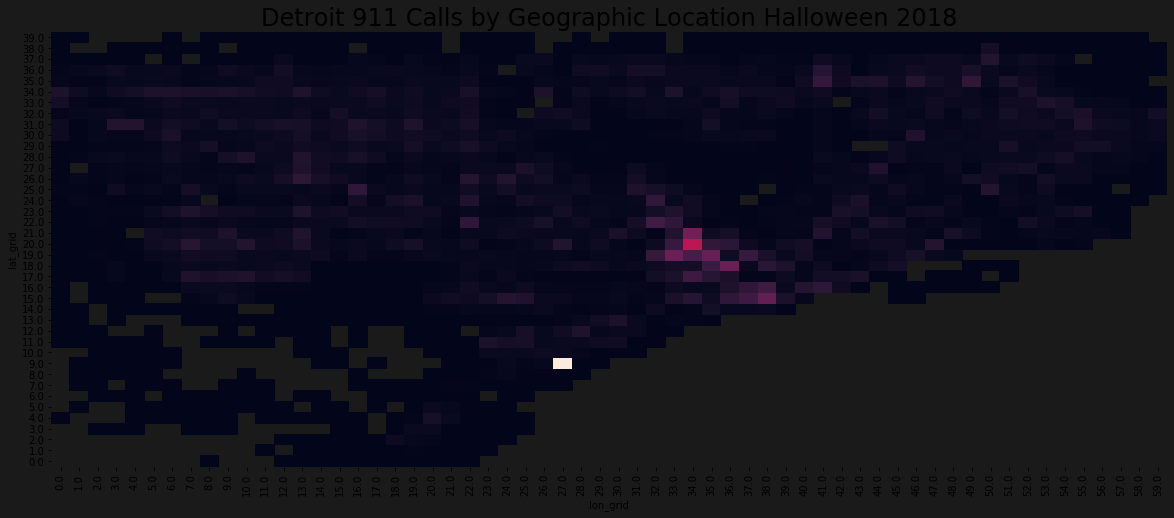

In [155]:
plot_calls_grid(geoheatmap_df)

In [163]:
import plotly.express as px
import plotly.io as pio

In [164]:
px.density_heatmap(geoheatmap_df).show()